# Effect of weather on AFL Games

## Introduction

The objective of this project is to determine whether or not variables such as rainfall effect scoring in games of AFL played at the M.C.G, with games from 2015 to 2019.

Table of contents:

Overview section
* Data Preparation
* Some other section
* Another section

## Data Preparation

### Preliminaries

In [82]:
# Module Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
# Read & Clean Game Data

gameData = pd.read_csv('data/all_games_2015_2019.csv', sep = ',')
gameData = gameData.drop(columns = ['id', 'Round'])
gameData['Date'] = gameData['Date'].str.split(' ').str[0]

indexNames = gameData[gameData['Venue'] != 'M.C.G.'].index
gameData.drop(indexNames, inplace=True)

# Read & Clean Weather Data

weather2015 = pd.read_csv('data/IDCJAC0009_086338_2015_Data.csv', sep = ',')
weather2016 = pd.read_csv('data/IDCJAC0009_086338_2016_Data.csv', sep = ',')
weather2017 = pd.read_csv('data/IDCJAC0009_086338_2017_Data.csv', sep = ',')
weather2018 = pd.read_csv('data/IDCJAC0009_086338_2018_Data.csv', sep = ',')
weather2019 = pd.read_csv('data/IDCJAC0009_086338_2019_Data.csv', sep = ',')
weatherData = pd.concat([weather2015, weather2016, weather2017, weather2018, weather2019])

weatherData['Month'] = weatherData['Month'].map(lambda x: str(x).zfill(2))
weatherData['Day'] = weatherData['Day'].map(lambda x: str(x).zfill(2))
weatherData['Date'] = weatherData['Year'].astype(str) + '-' + weatherData['Month'] + '-' + weatherData['Day'].astype(str)

weatherData = weatherData.drop(columns = ['Year', 'Month', 'Day', 'Product code', 'Bureau of Meteorology station number', 'Period over which rainfall was measured (days)', 'Quality'])

# Combined Data Sets

data = pd.merge(left = gameData, left_on='Date', right = weatherData, right_on='Date')


In [84]:
data

,Date,Venue,Round.Number,Home.Team,Home.Goals,Home.Behinds,Home.Points,Away.Team,Away.Goals,Away.Behinds,Away.Points,Margin,Rainfall amount (millimetres)
0,2015-04-02,M.C.G.,1,Carlton,11,12,78,Richmond,15,15,105,-27,0.2
1,2015-04-04,M.C.G.,1,Melbourne,17,13,115,Gold Coast,13,11,89,26,0.0
2,2015-04-06,M.C.G.,1,Hawthorn,17,21,123,Geelong,8,13,61,62,0.0
3,2015-04-11,M.C.G.,2,Richmond,9,12,66,Footscray,12,13,85,-19,0.0
4,2015-04-12,M.C.G.,2,Essendon,12,6,78,Hawthorn,11,10,76,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019-09-06,M.C.G.,24,Collingwood,9,7,61,Geelong,7,9,51,10,2.0
246,2019-09-13,M.C.G.,25,Geelong,13,10,88,West Coast,10,8,68,20,0.0
247,2019-09-20,M.C.G.,26,Richmond,12,13,85,Geelong,9,12,66,19,0.0
248,2019-09-21,M.C.G.,26,GWS,8,8,56,Collingwood,7,10,52,4,0.0


In [85]:
data.shape

(250, 13)

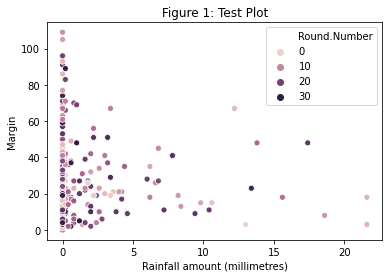

In [90]:
# create scatterplot 
sns.scatterplot(data['Rainfall amount (millimetres)'], data['Margin'].abs(), hue = data['Round.Number'])
plt.title('Figure 1: Test Plot')
plt.legend(loc = 'upper right')
plt.show();

